In [72]:
import sys
import time
import os
import glob
import numpy
import pickle
import aifc
import math
import numpy as np
from numpy import NaN, Inf, arange, isscalar, array
from scipy.fftpack import rfft
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy.signal import lfilter, hamming
import imp

In [73]:
eps = 0.00000001

def dc_normalize(sig_array):
    sig_array_norm = sig_array.copy()
    sig_array_norm -= sig_array_norm.mean()
    sig_array_norm /= abs(sig_array_norm).max() + 1e-10
    return sig_array_norm


def zero_crossing_rate(frame):
    count = len(frame)
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero) / np.float64(count - 1.0)


def energy(frame):
    return np.sum(frame ** 2) / np.float64(len(frame))


def energy_entropy(frame, n_short_blocks=10):
    # total frame energy
    frame_energy = np.sum(frame ** 2)
    frame_length = len(frame)
    sub_win_len = int(np.floor(frame_length / n_short_blocks))
    if frame_length != sub_win_len * n_short_blocks:
        frame = frame[0:sub_win_len * n_short_blocks]

    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (frame_energy + eps)

    # Compute entropy of the normalized sub-frame energies:
    entropy = -np.sum(s * np.log2(s + eps))
    return entropy




def spectral_centroid_spread(fft_magnitude, sampling_rate):
    ind = (np.arange(1, len(fft_magnitude) + 1)) * \
          (sampling_rate / (2.0 * len(fft_magnitude)))

    Xt = fft_magnitude.copy()
    Xt_max = Xt.max()
    if Xt_max == 0:
        Xt = Xt / eps
    else:
        Xt = Xt / Xt_max

    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    centroid = (NUM / DEN)

    # Spread:
    spread = np.sqrt(np.sum(((ind - centroid) ** 2) * Xt) / DEN)

    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    spread = spread / (sampling_rate / 2.0)

    return centroid, spread


def spectral_entropy(signal, n_short_blocks=10):
    # number of frame samples
    num_frames = len(signal)

    # total spectral energy
    total_energy = np.sum(signal ** 2)

    # length of sub-frame
    sub_win_len = int(np.floor(num_frames / n_short_blocks))
    if num_frames != sub_win_len * n_short_blocks:
        signal = signal[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = signal.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (total_energy + eps)

    # compute spectral entropy
    entropy = -np.sum(s * np.log2(s + eps))

    return entropy


def spectral_flux(fft_magnitude, previous_fft_magnitude):
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + eps)
    previous_fft_sum = np.sum(previous_fft_magnitude + eps)
    sp_flux = np.sum(
        (fft_magnitude / fft_sum - previous_fft_magnitude /
         previous_fft_sum) ** 2)

    return sp_flux


def spectral_rolloff(signal, c):
    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + eps
    a = np.nonzero(cumulative_sum > threshold)[0]
    if len(a) > 0:
        sp_rolloff = np.float64(a[0]) / (float(fft_length))
    else:
        sp_rolloff = 0.0
    return sp_rolloff

def mfcc_filter_banks(sampling_rate, num_fft, lowfreq=133.33, linc=200 / 3, logsc=1.0711703, num_lin_filt=13, num_log_filt=27):
    if sampling_rate < 8000:
        nlogfil = 5

    # Total number of filters
    num_filt_total = num_lin_filt + num_log_filt

    # Compute frequency points of the triangle:
    frequencies = np.zeros(num_filt_total + 2)
    frequencies[:num_lin_filt] = lowfreq + np.arange(num_lin_filt) * linc
    frequencies[num_lin_filt:] = frequencies[num_lin_filt - 1] * logsc ** \
                                 np.arange(1, num_log_filt + 3)
    heights = 2. / (frequencies[2:] - frequencies[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((num_filt_total, num_fft))
    nfreqs = np.arange(num_fft) / (1. * num_fft) * sampling_rate

    for i in range(num_filt_total):
        low_freqs = frequencies[i]
        cent_freqs = frequencies[i + 1]
        high_freqs = frequencies[i + 2]

        lid = np.arange(np.floor(low_freqs * num_fft / sampling_rate) + 1,
                        np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        lslope = heights[i] / (cent_freqs - low_freqs)
        rid = np.arange(np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        np.floor(high_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        rslope = heights[i] / (high_freqs - cent_freqs)
        fbank[i][lid] = lslope * (nfreqs[lid] - low_freqs)
        fbank[i][rid] = rslope * (high_freqs - nfreqs[rid])

    return fbank, frequencies


def mfcc(fft_magnitude, fbank, num_mfcc_feats):
    mspec = np.log10(np.dot(fft_magnitude, fbank.T) + eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:num_mfcc_feats]
    return ceps


In [74]:
def feature_extraction(signal, sampling_rate, window, step, deltas=True):
    window = int(window)
    step = int(step)

    # signal normalization
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)

    signal = dc_normalize(signal)

    number_of_samples = len(signal)  # total number of samples
    current_position = 0
    count_fr = 0
    num_fft = int(window / 2)

    # compute the triangular filter banks used in the mfcc calculation
    fbank, freqs = mfcc_filter_banks(sampling_rate, num_fft)

    n_time_spectral_feats = 8
    #n_harmonic_feats = 0
    n_mfcc_feats = 13
    #n_chroma_feats = 13
    n_total_feats = n_time_spectral_feats + n_mfcc_feats 
    #    n_total_feats = n_time_spectral_feats + n_mfcc_feats +
    #    n_harmonic_feats

    # define list of feature names
    feature_names = ["zcr", "energy", "energy_entropy"]
    feature_names += ["spectral_centroid", "spectral_spread"]
    feature_names.append("spectral_entropy")
    feature_names.append("spectral_flux")
    feature_names.append("spectral_rolloff")
    feature_names += ["mfcc_{0:d}".format(mfcc_i)
                      for mfcc_i in range(1, n_mfcc_feats + 1)]
    

#     add names for delta features:
    if deltas:
        feature_names_2 = feature_names + ["delta " + f for f in feature_names]
        feature_names = feature_names_2

    features = []
    # for each short-term window to end of signal
    while current_position + window - 1 < number_of_samples:
        count_fr += 1
        # get current window
        x = signal[current_position:current_position + window]

        # update window position
        current_position = current_position + step

        # get fft magnitude
        fft_magnitude = abs(fft(x))

        # normalize fft
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)

        # keep previous fft mag (used in spectral flux)
        if count_fr == 1:
            fft_magnitude_previous = fft_magnitude.copy()
        feature_vector = np.zeros((n_total_feats, 1))

        # zero crossing rate
        feature_vector[0] = zero_crossing_rate(x)

        # short-term energy
        feature_vector[1] = energy(x)

        # short-term entropy of energy
        feature_vector[2] = energy_entropy(x)

        # sp centroid/spread
        [feature_vector[3], feature_vector[4]] = spectral_centroid_spread(fft_magnitude, sampling_rate)

        # spectral entropy
        feature_vector[5] = spectral_entropy(fft_magnitude)

        # spectral flux
        feature_vector[6] = spectral_flux(fft_magnitude,fft_magnitude_previous)

        # spectral rolloff
        feature_vector[7] = spectral_rolloff(fft_magnitude, 0.90)

        # MFCCs
        mffc_feats_end = n_time_spectral_feats + n_mfcc_feats
        feature_vector[n_time_spectral_feats:mffc_feats_end, 0] = mfcc(fft_magnitude, fbank, n_mfcc_feats).copy()

        if not deltas:
            features.append(feature_vector)
        else:
            # delta features
            if count_fr > 1:
                delta = feature_vector - feature_vector_prev
                feature_vector_2 = np.concatenate((feature_vector, delta))
            else:
                feature_vector_2 = np.concatenate((feature_vector,np.zeros(feature_vector.shape)))
            feature_vector_prev = feature_vector
            features.append(feature_vector_2)

        fft_magnitude_previous = fft_magnitude.copy()

    features = np.concatenate(features, 1)
    return features, feature_names

In [75]:
from pyAudioAnalysis import audioBasicIO as aIO
import plotly.graph_objs as go 
import plotly
import IPython

In [76]:
fs, s = aIO.read_audio_file("Downloads\\drum.wav")
IPython.display.display(IPython.display.Audio("Downloads\\drum.wav"))

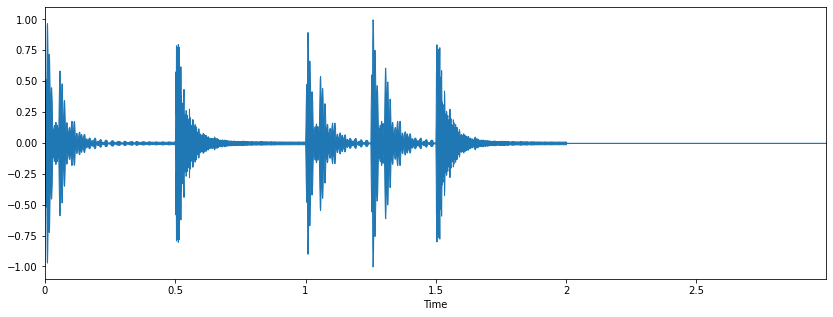

In [77]:
%matplotlib inline
# import matplotlib.pyplot as plt
import librosa.display
x, sr= librosa.load('drum.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [78]:
duration = len(s) / float(fs)
print(f'duration = {duration} seconds')

duration = 3.0 seconds


In [79]:
win, step = 0.050, 0.050
[f, fn] = feature_extraction(s, fs, int(fs*win), int(fs*step))
print(f'{f.shape[1]} frames, {f.shape[0]} short-term features')
print('Feature names:')
for i, nam in enumerate(fn):
    print(f'{i}:{nam}')

<ipython-input-73-e3fda5c9d487>:142: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<ipython-input-73-e3fda5c9d487>:146: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: http

60 frames, 42 short-term features
Feature names:
0:zcr
1:energy
2:energy_entropy
3:spectral_centroid
4:spectral_spread
5:spectral_entropy
6:spectral_flux
7:spectral_rolloff
8:mfcc_1
9:mfcc_2
10:mfcc_3
11:mfcc_4
12:mfcc_5
13:mfcc_6
14:mfcc_7
15:mfcc_8
16:mfcc_9
17:mfcc_10
18:mfcc_11
19:mfcc_12
20:mfcc_13
21:delta zcr
22:delta energy
23:delta energy_entropy
24:delta spectral_centroid
25:delta spectral_spread
26:delta spectral_entropy
27:delta spectral_flux
28:delta spectral_rolloff
29:delta mfcc_1
30:delta mfcc_2
31:delta mfcc_3
32:delta mfcc_4
33:delta mfcc_5
34:delta mfcc_6
35:delta mfcc_7
36:delta mfcc_8
37:delta mfcc_9
38:delta mfcc_10
39:delta mfcc_11
40:delta mfcc_12
41:delta mfcc_13


In [80]:
time = np.arange(0, duration - step, win) 
# get the feature whose name is 'energy'
energy = f[fn.index('spectral_flux'), :]
mylayout = go.Layout(yaxis=dict(title="spectral_flux value"),xaxis=dict(title="time (sec)"))

plotly.offline.iplot(go.Figure(data=[go.Scatter(x=time, y=energy)], layout=mylayout))

In [81]:
energy = f[fn.index('zcr'), :]
mylayout = go.Layout(yaxis=dict(title="ZCR value"),xaxis=dict(title="time (sec)"))
plotly.offline.iplot(go.Figure(data=[go.Scatter(x=time, y=energy)], layout=mylayout))

In [82]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt

def beat_extraction(short_features, window_size, plot=False):
    # Features that are related to the beat tracking task:
    selected_features = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10,
                         11, 12, 13, 14, 15, 16, 17, 18]

    max_beat_time = int(round(2.0 / window_size))
    hist_all = np.zeros((max_beat_time,))
    # for each feature
    for ii, i in enumerate(selected_features):
        # dif threshold (3 x Mean of Difs)
        dif_threshold = 2.0 * (np.abs(short_features[i, 0:-1] -
                                      short_features[i, 1::])).mean()
        if dif_threshold <= 0:
            dif_threshold = 0.0000000000000001
        # detect local maxima
        [pos1, _] = utilities.peakdet(short_features[i, :], dif_threshold)
        position_diffs = []
        # compute histograms of local maxima changes
        for j in range(len(pos1)-1):
            position_diffs.append(pos1[j+1]-pos1[j])
        histogram_times, histogram_edges = \
            np.histogram(position_diffs, np.arange(0.5, max_beat_time + 1.5))
        hist_centers = (histogram_edges[0:-1] + histogram_edges[1::]) / 2.0
        histogram_times = \
            histogram_times.astype(float) / short_features.shape[1]
        hist_all += histogram_times
        if plot:
            plt.subplot(9, 2, ii + 1)
            plt.plot(short_features[i, :], 'k')
            for k in pos1:
                plt.plot(k, short_features[i, k], 'k*')
            f1 = plt.gca()
            f1.axes.get_xaxis().set_ticks([])
            f1.axes.get_yaxis().set_ticks([])

    if plot:
        plt.show(block=False)
        plt.figure()

    # Get beat as the argmax of the agregated histogram:
    max_indices = np.argmax(hist_all)
    bpms = 60 / (hist_centers * window_size)
    bpm = bpms[max_indices]
    # ... and the beat ratio:
    ratio = hist_all[max_indices] / (hist_all.sum() + eps)

    if plot:
        # filter out >500 beats from plotting:
        hist_all = hist_all[bpms < 500]
        bpms = bpms[bpms < 500]

        plt.plot(bpms, hist_all, 'k')
        plt.xlabel('Beats per minute')
        plt.ylabel('Freq Count')
        plt.show(block=True)

    return bpm, ratio


def mid_feature_extraction(signal, sampling_rate, mid_window, mid_step,short_window, short_step):
    short_features, short_feature_names = feature_extraction(signal, sampling_rate,
                                             short_window, short_step)

    n_stats = 2
    n_feats = len(short_features)
    #mid_window_ratio = int(round(mid_window / short_step))
    mid_window_ratio = round((mid_window -
                              (short_window - short_step)) / short_step)
    mt_step_ratio = int(round(mid_step / short_step))

    mid_features, mid_feature_names = [], []
    for i in range(n_stats * n_feats):
        mid_features.append([])
        mid_feature_names.append("")

    # for each of the short-term features:
    for i in range(n_feats):
        cur_position = 0
        num_short_features = len(short_features[i])
        mid_feature_names[i] = short_feature_names[i] + "_" + "mean"
        mid_feature_names[i + n_feats] = short_feature_names[i] + "_" + "std"

        while cur_position < num_short_features:
            end = cur_position + mid_window_ratio
            if end > num_short_features:
                end = num_short_features
            cur_st_feats = short_features[i][cur_position:end]

            mid_features[i].append(np.mean(cur_st_feats))
            mid_features[i + n_feats].append(np.std(cur_st_feats))
            cur_position += mt_step_ratio
    mid_features = np.array(mid_features)
    mid_features = np.nan_to_num(mid_features)
    return mid_features, short_features, mid_feature_names



def directory_feature_extraction(folder_path, mid_window, mid_step,short_window, short_step, compute_beat=True):
    mid_term_features = np.array([])
    process_times = []

    types = ('*.wav', '*.aif',  '*.aiff', '*.mp3', '*.au', '*.ogg')
    wav_file_list = []
    for files in types:
        wav_file_list.extend(glob.glob(os.path.join(folder_path, files)))

    wav_file_list = sorted(wav_file_list)    
    wav_file_list2, mid_feature_names = [], []
    for i, file_path in enumerate(wav_file_list):
        print("Analyzing file {0:d} of {1:d}: {2:s}".format(i + 1,
                                                            len(wav_file_list),
                                                            file_path))
        if os.stat(file_path).st_size == 0:
            print("   (EMPTY FILE -- SKIPPING)")
            continue        
        sampling_rate, signal = aIO.read_audio_file(file_path)
        if sampling_rate == 0:
            continue        

        t1 = time.time()        
        signal = aIO.stereo_to_mono(signal)
        if signal.shape[0] < float(sampling_rate)/5:
            print("  (AUDIO FILE TOO SMALL - SKIPPING)")
            continue
        wav_file_list2.append(file_path)
        if compute_beat:
            mid_features, short_features, mid_feature_names = \
                mid_feature_extraction(signal, sampling_rate,round(mid_window * sampling_rate),
                                       round(mid_step * sampling_rate),round(sampling_rate * short_window),
                                       round(sampling_rate * short_step))
            beat, beat_conf = beat_extraction(short_features, short_step)
        else:
            mid_features, _, mid_feature_names = mid_feature_extraction(signal, sampling_rate,
                                       round(mid_window * sampling_rate),round(mid_step * sampling_rate),
                                       round(sampling_rate * short_window),round(sampling_rate * short_step))

        mid_features = np.transpose(mid_features)
        mid_features = mid_features.mean(axis=0)
        # long term averaging of mid-term statistics
        if (not np.isnan(mid_features).any()) and \
                (not np.isinf(mid_features).any()):
            if compute_beat:
                mid_features = np.append(mid_features, beat)
                mid_features = np.append(mid_features, beat_conf)
            if len(mid_term_features) == 0:
                # append feature vector
                mid_term_features = mid_features
            else:
                mid_term_features = np.vstack((mid_term_features, mid_features))
            t2 = time.time()
            duration = float(len(signal)) / sampling_rate
            process_times.append((t2 - t1) / duration)
    if len(process_times) > 0:
        print("Feature extraction complexity ratio: "
              "{0:.1f} x realtime".format((1.0 / np.mean(np.array(process_times)))))
    return mid_term_features, wav_file_list2, mid_feature_names

In [90]:
from pyAudioAnalysis import MidTermFeatures as aF
dirs = ["C:\\Users\\saurabh\\Downloads\\training_data\\blues",
       "C:\\Users\\saurabh\\Downloads\\training_data\\classical",
       "C:\\Users\\saurabh\\Downloads\\training_data\\country",
       "C:\\Users\\saurabh\\Downloads\\training_data\\disco",
       "C:\\Users\\saurabh\\Downloads\\training_data\\hiphop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\jazz",
       "C:\\Users\\saurabh\\Downloads\\training_data\\metal",
       "C:\\Users\\saurabh\\Downloads\\training_data\\pop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\reggae",
       "C:\\Users\\saurabh\\Downloads\\training_data0\\rock"]
class_names = [os.path.basename(d) for d in dirs]
m_win, m_step, s_win, s_step = 1, 1, 0.1, 0.05
features = [] 
for d in dirs: # get feature matrix for each directory (class) 
    f, files, fn = aF.directory_feature_extraction(d, m_win, m_step,s_win, s_step) 
    features.append(f)
# (each element of the features list contains a 
# (samples x segment features) = (10 x 138) feature matrix)


Analyzing file 1 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00000.wav
Analyzing file 2 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00001.wav
Analyzing file 3 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00002.wav
Analyzing file 4 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00003.wav
Analyzing file 5 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00004.wav
Analyzing file 6 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00005.wav
Analyzing file 7 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00006.wav
Analyzing file 8 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00007.wav
Analyzing file 9 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00008.wav
Analyzing file 10 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00009.wav
Analyzing file 11 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00010.wav
Analyzing file 12 of 50: C:\Users\saurabh

Analyzing file 41 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00040.wav
Analyzing file 42 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00041.wav
Analyzing file 43 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00042.wav
Analyzing file 44 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00043.wav
Analyzing file 45 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00044.wav
Analyzing file 46 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00045.wav
Analyzing file 47 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00046.wav
Analyzing file 48 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00047.wav
Analyzing file 49 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00048.wav
Analyzing file 50 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00049.wav
Feature extraction complexity ratio: 12.

Analyzing file 30 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00029.wav
Analyzing file 31 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00030.wav
Analyzing file 32 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00031.wav
Analyzing file 33 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00032.wav
Analyzing file 34 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00033.wav
Analyzing file 35 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00034.wav
Analyzing file 36 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00035.wav
Analyzing file 37 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00036.wav
Analyzing file 38 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00037.wav
Analyzing file 39 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00038.wav
Analyzing file 40 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00039.wav
Analyzing file 41 of 50: C:\User

Analyzing file 22 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00021.wav
Analyzing file 23 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00022.wav
Analyzing file 24 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00023.wav
Analyzing file 25 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00024.wav
Analyzing file 26 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00025.wav
Analyzing file 27 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00026.wav
Analyzing file 28 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00027.wav
Analyzing file 29 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00028.wav
Analyzing file 30 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00029.wav
Analyzing file 31 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00030.wav
Analyzing file 32 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00031.wav
Analyzing file 33 of 50: C:\Users\saurabh\Downloads\tr

Analyzing file 16 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00015.wav
Analyzing file 17 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00016.wav
Analyzing file 18 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00017.wav
Analyzing file 19 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00018.wav
Analyzing file 20 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00019.wav
Analyzing file 21 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00020.wav
Analyzing file 22 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00021.wav
Analyzing file 23 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00022.wav
Analyzing file 24 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00023.wav
Analyzing file 25 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00024.wav
Analyzing file 26 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00025.wav
Analyzing file 27 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00

Analyzing file 9 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00008.wav
Analyzing file 10 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00009.wav
Analyzing file 11 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00010.wav
Analyzing file 12 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00011.wav
Analyzing file 13 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00012.wav
Analyzing file 14 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00013.wav
Analyzing file 15 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00014.wav
Analyzing file 16 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00015.wav
Analyzing file 17 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00016.wav
Analyzing file 18 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00017.wav
Analyzing file 19 of 50: C:\Users\saurabh\Downloads\training_data\rock\rock.00018.wav
Analyzing file 20 of 50: C:\Users\saurabh\Downloads\tra

In [97]:
print(features[0].shape)
print(features[1].shape)
print(features[2].shape)

(50, 138)
(50, 138)
(50, 138)


In [95]:
f1 = np.array([features[0][:, fn.index('spectral_centroid_mean')],
               features[0][:, fn.index('energy_entropy_mean')]])
f2 = np.array([features[1][:, fn.index('spectral_centroid_mean')],
               features[1][:, fn.index('energy_entropy_mean')]])

f3 = np.array([features[2][:, fn.index('spectral_centroid_mean')],
               features[2][:, fn.index('energy_entropy_mean')]])

f4 = np.array([features[3][:, fn.index('spectral_centroid_mean')],
               features[3][:, fn.index('energy_entropy_mean')]])

f5 = np.array([features[4][:, fn.index('spectral_centroid_mean')],
               features[4][:, fn.index('energy_entropy_mean')]])

f6 = np.array([features[5][:, fn.index('spectral_centroid_mean')],
               features[5][:, fn.index('energy_entropy_mean')]])

f7 = np.array([features[6][:, fn.index('spectral_centroid_mean')],
               features[6][:, fn.index('energy_entropy_mean')]])

f8 = np.array([features[7][:, fn.index('spectral_centroid_mean')],
               features[7][:, fn.index('energy_entropy_mean')]])

f9 = np.array([features[8][:, fn.index('spectral_centroid_mean')],
               features[8][:, fn.index('energy_entropy_mean')]])

f10 = np.array([features[9][:, fn.index('spectral_centroid_mean')],
               features[9][:, fn.index('energy_entropy_mean')]])

# plot 2D features
plots = [go.Scatter(x=f1[0, :],  y=f1[1, :], 
                    name=class_names[0], mode='markers'),
         go.Scatter(x=f2[0, :], y=f2[1, :], 
                    name=class_names[1], mode='markers'),
        go.Scatter(x=f3[0, :], y=f3[1, :], 
                    name=class_names[2], mode='markers'),
        go.Scatter(x=f4[0, :], y=f4[1, :], 
                    name=class_names[3], mode='markers'),
        go.Scatter(x=f5[0, :], y=f5[1, :], 
                    name=class_names[4], mode='markers'),
        go.Scatter(x=f6[0, :], y=f6[1, :], 
                    name=class_names[5], mode='markers'),
        go.Scatter(x=f7[0, :], y=f7[1, :], 
                    name=class_names[6], mode='markers'),
        go.Scatter(x=f8[0, :], y=f8[1, :], 
                    name=class_names[7], mode='markers'),
        go.Scatter(x=f9[0, :], y=f9[1, :], 
                    name=class_names[8], mode='markers'),
        go.Scatter(x=f10[0, :], y=f10[1, :], 
                    name=class_names[9], mode='markers')]
mylayout = go.Layout(xaxis=dict(title="spectral_centroid_mean"),
                     yaxis=dict(title="energy_entropy_mean"))
plotly.offline.iplot(go.Figure(data=plots, layout=mylayout))

In [35]:
from sklearn.svm import SVC
import plotly.graph_objs as go 
import plotly

In [98]:
p1 = go.Scatter(x=f1[0, :],  y=f1[1, :], name=class_names[0],
                marker=dict(size=10,color='rgba(255, 182, 193, .9)'),
                mode='markers')
p2 = go.Scatter(x=f2[0, :], y=f2[1, :],  name=class_names[1], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p3 = go.Scatter(x=f3[0, :], y=f3[1, :],  name=class_names[2], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p4 = go.Scatter(x=f4[0, :], y=f4[1, :],  name=class_names[3], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p5 = go.Scatter(x=f5[0, :], y=f5[1, :],  name=class_names[4], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p6 = go.Scatter(x=f6[0, :], y=f6[1, :],  name=class_names[5], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p7 = go.Scatter(x=f7[0, :], y=f7[1, :],  name=class_names[6], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p8 = go.Scatter(x=f8[0, :], y=f8[1, :],  name=class_names[7], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p9 = go.Scatter(x=f9[0, :], y=f9[1, :],  name=class_names[8], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
p10 = go.Scatter(x=f10[0, :], y=f10[1, :],  name=class_names[9], 
                marker=dict(size=10,color='rgba(100, 100, 220, .9)'),
                mode='markers')
mylayout = go.Layout(xaxis=dict(title="spectral_centroid_mean"),
                     yaxis=dict(title="energy_entropy_mean"))
y = np.concatenate((np.zeros(f1.shape[1]), np.ones(f2.shape[1]))) 
f = np.concatenate((f1.T, f2.T), axis = 0)
# train the svm classifier
cl = SVC(kernel='rbf', C=20) 
cl.fit(f, y) 
# apply the trained model on the points of a grid
x_ = np.arange(f[:, 0].min(), f[:, 0].max(), 0.002) 
y_ = np.arange(f[:, 1].min(), f[:, 1].max(), 0.002) 
xx, yy = np.meshgrid(x_, y_) 
Z = cl.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape) / 2 
# and visualize the grid on the same plot (decision surfaces)
cs = go.Heatmap(x=x_, y=y_, z=Z, showscale=False, 
               colorscale= [[0, 'rgba(255, 182, 193, .3)'], 
                           [1, 'rgba(100, 100, 220, .3)']]) 
mylayout = go.Layout(xaxis=dict(title="spectral_centroid_mean"),
                     yaxis=dict(title="energy_entropy_mean"))
plotly.offline.iplot(go.Figure(data=[p1, p2, cs], layout=mylayout))

In [103]:
from pyAudioAnalysis.audioTrainTest import extract_features_and_train
mt, st = 1.0, 0.05
dirs = ["C:\\Users\\saurabh\\Downloads\\training_data\\blues",
       "C:\\Users\\saurabh\\Downloads\\training_data\\classical",
       "C:\\Users\\saurabh\\Downloads\\training_data\\country",
       "C:\\Users\\saurabh\\Downloads\\training_data\\disco",
       "C:\\Users\\saurabh\\Downloads\\training_data\\hiphop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\jazz",
       "C:\\Users\\saurabh\\Downloads\\training_data\\metal",
       "C:\\Users\\saurabh\\Downloads\\training_data\\pop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\reggae",
       "C:\\Users\\saurabh\\Downloads\\training_data0\\rock"]
class_names = [os.path.basename(d) for d in dirs] 
extract_features_and_train(dirs, mt, mt, st, st, "knn", "Classification_model")

Analyzing file 1 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00000.wav
Analyzing file 2 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00001.wav
Analyzing file 3 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00002.wav
Analyzing file 4 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00003.wav
Analyzing file 5 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00004.wav
Analyzing file 6 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00005.wav
Analyzing file 7 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00006.wav
Analyzing file 8 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00007.wav
Analyzing file 9 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00008.wav
Analyzing file 10 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00009.wav
Analyzing file 11 of 50: C:\Users\saurabh\Downloads\training_data\blues\blues.00010.wav
Analyzing file 12 of 50: C:\Users\saurabh

Analyzing file 41 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00040.wav
Analyzing file 42 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00041.wav
Analyzing file 43 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00042.wav
Analyzing file 44 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00043.wav
Analyzing file 45 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00044.wav
Analyzing file 46 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00045.wav
Analyzing file 47 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00046.wav
Analyzing file 48 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00047.wav
Analyzing file 49 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00048.wav
Analyzing file 50 of 50: C:\Users\saurabh\Downloads\training_data\classical\classical.00049.wav
Feature extraction complexity ratio: 9.6

Analyzing file 30 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00029.wav
Analyzing file 31 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00030.wav
Analyzing file 32 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00031.wav
Analyzing file 33 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00032.wav
Analyzing file 34 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00033.wav
Analyzing file 35 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00034.wav
Analyzing file 36 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00035.wav
Analyzing file 37 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00036.wav
Analyzing file 38 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00037.wav
Analyzing file 39 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00038.wav
Analyzing file 40 of 50: C:\Users\saurabh\Downloads\training_data\disco\disco.00039.wav
Analyzing file 41 of 50: C:\User

Analyzing file 22 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00021.wav
Analyzing file 23 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00022.wav
Analyzing file 24 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00023.wav
Analyzing file 25 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00024.wav
Analyzing file 26 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00025.wav
Analyzing file 27 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00026.wav
Analyzing file 28 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00027.wav
Analyzing file 29 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00028.wav
Analyzing file 30 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00029.wav
Analyzing file 31 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00030.wav
Analyzing file 32 of 50: C:\Users\saurabh\Downloads\training_data\jazz\jazz.00031.wav
Analyzing file 33 of 50: C:\Users\saurabh\Downloads\tr

Analyzing file 16 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00015.wav
Analyzing file 17 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00016.wav
Analyzing file 18 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00017.wav
Analyzing file 19 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00018.wav
Analyzing file 20 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00019.wav
Analyzing file 21 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00020.wav
Analyzing file 22 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00021.wav
Analyzing file 23 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00022.wav
Analyzing file 24 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00023.wav
Analyzing file 25 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00024.wav
Analyzing file 26 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00025.wav
Analyzing file 27 of 50: C:\Users\saurabh\Downloads\training_data\pop\pop.00

Param = 1.00000 - classifier Evaluation Experiment 28 of 100
Param = 1.00000 - classifier Evaluation Experiment 29 of 100
Param = 1.00000 - classifier Evaluation Experiment 30 of 100
Param = 1.00000 - classifier Evaluation Experiment 31 of 100
Param = 1.00000 - classifier Evaluation Experiment 32 of 100
Param = 1.00000 - classifier Evaluation Experiment 33 of 100
Param = 1.00000 - classifier Evaluation Experiment 34 of 100
Param = 1.00000 - classifier Evaluation Experiment 35 of 100
Param = 1.00000 - classifier Evaluation Experiment 36 of 100
Param = 1.00000 - classifier Evaluation Experiment 37 of 100
Param = 1.00000 - classifier Evaluation Experiment 38 of 100
Param = 1.00000 - classifier Evaluation Experiment 39 of 100
Param = 1.00000 - classifier Evaluation Experiment 40 of 100
Param = 1.00000 - classifier Evaluation Experiment 41 of 100
Param = 1.00000 - classifier Evaluation Experiment 42 of 100
Param = 1.00000 - classifier Evaluation Experiment 43 of 100
Param = 1.00000 - classi

Param = 3.00000 - classifier Evaluation Experiment 81 of 100
Param = 3.00000 - classifier Evaluation Experiment 82 of 100
Param = 3.00000 - classifier Evaluation Experiment 83 of 100
Param = 3.00000 - classifier Evaluation Experiment 84 of 100
Param = 3.00000 - classifier Evaluation Experiment 85 of 100
Param = 3.00000 - classifier Evaluation Experiment 86 of 100
Param = 3.00000 - classifier Evaluation Experiment 87 of 100
Param = 3.00000 - classifier Evaluation Experiment 88 of 100
Param = 3.00000 - classifier Evaluation Experiment 89 of 100
Param = 3.00000 - classifier Evaluation Experiment 90 of 100
Param = 3.00000 - classifier Evaluation Experiment 91 of 100
Param = 3.00000 - classifier Evaluation Experiment 92 of 100
Param = 3.00000 - classifier Evaluation Experiment 93 of 100
Param = 3.00000 - classifier Evaluation Experiment 94 of 100
Param = 3.00000 - classifier Evaluation Experiment 95 of 100
Param = 3.00000 - classifier Evaluation Experiment 96 of 100
Param = 3.00000 - classi

Param = 7.00000 - classifier Evaluation Experiment 18 of 100
Param = 7.00000 - classifier Evaluation Experiment 19 of 100
Param = 7.00000 - classifier Evaluation Experiment 20 of 100
Param = 7.00000 - classifier Evaluation Experiment 21 of 100
Param = 7.00000 - classifier Evaluation Experiment 22 of 100
Param = 7.00000 - classifier Evaluation Experiment 23 of 100
Param = 7.00000 - classifier Evaluation Experiment 24 of 100
Param = 7.00000 - classifier Evaluation Experiment 25 of 100
Param = 7.00000 - classifier Evaluation Experiment 26 of 100
Param = 7.00000 - classifier Evaluation Experiment 27 of 100
Param = 7.00000 - classifier Evaluation Experiment 28 of 100
Param = 7.00000 - classifier Evaluation Experiment 29 of 100
Param = 7.00000 - classifier Evaluation Experiment 30 of 100
Param = 7.00000 - classifier Evaluation Experiment 31 of 100
Param = 7.00000 - classifier Evaluation Experiment 32 of 100
Param = 7.00000 - classifier Evaluation Experiment 33 of 100
Param = 7.00000 - classi

Param = 9.00000 - classifier Evaluation Experiment 64 of 100
Param = 9.00000 - classifier Evaluation Experiment 65 of 100
Param = 9.00000 - classifier Evaluation Experiment 66 of 100
Param = 9.00000 - classifier Evaluation Experiment 67 of 100
Param = 9.00000 - classifier Evaluation Experiment 68 of 100
Param = 9.00000 - classifier Evaluation Experiment 69 of 100
Param = 9.00000 - classifier Evaluation Experiment 70 of 100
Param = 9.00000 - classifier Evaluation Experiment 71 of 100
Param = 9.00000 - classifier Evaluation Experiment 72 of 100
Param = 9.00000 - classifier Evaluation Experiment 73 of 100
Param = 9.00000 - classifier Evaluation Experiment 74 of 100
Param = 9.00000 - classifier Evaluation Experiment 75 of 100
Param = 9.00000 - classifier Evaluation Experiment 76 of 100
Param = 9.00000 - classifier Evaluation Experiment 77 of 100
Param = 9.00000 - classifier Evaluation Experiment 78 of 100
Param = 9.00000 - classifier Evaluation Experiment 79 of 100
Param = 9.00000 - classi

Param = 13.00000 - classifier Evaluation Experiment 5 of 100
Param = 13.00000 - classifier Evaluation Experiment 6 of 100
Param = 13.00000 - classifier Evaluation Experiment 7 of 100
Param = 13.00000 - classifier Evaluation Experiment 8 of 100
Param = 13.00000 - classifier Evaluation Experiment 9 of 100
Param = 13.00000 - classifier Evaluation Experiment 10 of 100
Param = 13.00000 - classifier Evaluation Experiment 11 of 100
Param = 13.00000 - classifier Evaluation Experiment 12 of 100
Param = 13.00000 - classifier Evaluation Experiment 13 of 100
Param = 13.00000 - classifier Evaluation Experiment 14 of 100
Param = 13.00000 - classifier Evaluation Experiment 15 of 100
Param = 13.00000 - classifier Evaluation Experiment 16 of 100
Param = 13.00000 - classifier Evaluation Experiment 17 of 100
Param = 13.00000 - classifier Evaluation Experiment 18 of 100
Param = 13.00000 - classifier Evaluation Experiment 19 of 100
Param = 13.00000 - classifier Evaluation Experiment 20 of 100
Param = 13.00

Param = 15.00000 - classifier Evaluation Experiment 40 of 100
Param = 15.00000 - classifier Evaluation Experiment 41 of 100
Param = 15.00000 - classifier Evaluation Experiment 42 of 100
Param = 15.00000 - classifier Evaluation Experiment 43 of 100
Param = 15.00000 - classifier Evaluation Experiment 44 of 100
Param = 15.00000 - classifier Evaluation Experiment 45 of 100
Param = 15.00000 - classifier Evaluation Experiment 46 of 100
Param = 15.00000 - classifier Evaluation Experiment 47 of 100
Param = 15.00000 - classifier Evaluation Experiment 48 of 100
Param = 15.00000 - classifier Evaluation Experiment 49 of 100
Param = 15.00000 - classifier Evaluation Experiment 50 of 100
Param = 15.00000 - classifier Evaluation Experiment 51 of 100
Param = 15.00000 - classifier Evaluation Experiment 52 of 100
Param = 15.00000 - classifier Evaluation Experiment 53 of 100
Param = 15.00000 - classifier Evaluation Experiment 54 of 100
Param = 15.00000 - classifier Evaluation Experiment 55 of 100
Param = 

In [104]:
from pyAudioAnalysis import audioTrainTest as aT
files_to_test = ["C:\\Users\\saurabh\\Downloads\\training_data\\testing files\\blues.00096.wav",
                 "C:\\Users\\saurabh\\Downloads\\training_data\\testing files\\classical.00053.wav",
                 "C:\\Users\\saurabh\\Downloads\\training_data\\testing files\\hiphop.00092.wav",
                "C:\\Users\\saurabh\\Downloads\\training_data\\testing files\\pop.00055.wav"]
for f in files_to_test:
    print(f'{f}:')
    c, p, p_nam = aT.file_classification(f, "Classification_model","knn")
#     print(f'P({p_nam[0]}={p[0]})')
#     print(f'P({p_nam[1]}={p[1]})')
#     print()

C:\Users\saurabh\Downloads\training_data\testing files\blues.00096.wav:
C:\Users\saurabh\Downloads\training_data\testing files\classical.00053.wav:
C:\Users\saurabh\Downloads\training_data\testing files\hiphop.00092.wav:
C:\Users\saurabh\Downloads\training_data\testing files\pop.00055.wav:


In [105]:
from pyAudioAnalysis import audioTrainTest as aT
aT.evaluate_model_for_folders(["C:\\Users\\saurabh\\Downloads\\training_data\\blues",
       "C:\\Users\\saurabh\\Downloads\\training_data\\classical",
       "C:\\Users\\saurabh\\Downloads\\training_data\\country",
       "C:\\Users\\saurabh\\Downloads\\training_data\\disco",
       "C:\\Users\\saurabh\\Downloads\\training_data\\hiphop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\jazz",
       "C:\\Users\\saurabh\\Downloads\\training_data\\metal",
       "C:\\Users\\saurabh\\Downloads\\training_data\\pop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\reggae",
       "C:\\Users\\saurabh\\Downloads\\training_data0\\rock"],
                              "Classification_model", 
                              "knn", 
                              "classical", True)

[[46  0  1  0  0  3  0  0  0]
 [ 0 49  0  0  0  1  0  0  0]
 [ 0  3 37  2  0  1  2  5  0]
 [ 0  1  2 29  0  0  2 15  1]
 [ 0  0  0  4 29  1  0  8  8]
 [ 2 10  4  1  0 33  0  0  0]
 [ 0  0  2  0  0  0 48  0  0]
 [ 0  1  3  2  0  1  1 42  0]
 [ 0  0  4  3  0  0  0  2 41]]
[0.92, 0.98, 0.74, 0.58, 0.58, 0.66, 0.96, 0.84, 0.82] [0.9583333333333334, 0.765625, 0.6981132075471698, 0.7073170731707317, 1.0, 0.825, 0.9056603773584906, 0.5833333333333334, 0.82] [0.9387755102040817, 0.8596491228070174, 0.7184466019417476, 0.6373626373626374, 0.7341772151898733, 0.7333333333333334, 0.9320388349514563, 0.6885245901639344, 0.82] 0.7847008717726758 0.7866666666666666


(array([[46,  0,  1,  0,  0,  3,  0,  0,  0],
        [ 0, 49,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  3, 37,  2,  0,  1,  2,  5,  0],
        [ 0,  1,  2, 29,  0,  0,  2, 15,  1],
        [ 0,  0,  0,  4, 29,  1,  0,  8,  8],
        [ 2, 10,  4,  1,  0, 33,  0,  0,  0],
        [ 0,  0,  2,  0,  0,  0, 48,  0,  0],
        [ 0,  1,  3,  2,  0,  1,  1, 42,  0],
        [ 0,  0,  4,  3,  0,  0,  0,  2, 41]], dtype=int64),
 array([0.28571429, 0.42857143, 0.57142857, 0.71428571, 0.85714286,
        1.        ]),
 array([0.66666667, 0.74242424, 0.81481481, 0.87234043, 0.95652174,
        1.        , 1.        ]),
 array([1.  , 0.98, 0.88, 0.82, 0.44, 0.08, 0.  ]),
 array([2.        , 1.        , 0.85714286, 0.71428571, 0.57142857,
        0.42857143, 0.28571429, 0.14285714, 0.        ]),
 array([0.    , 0.    , 0.0025, 0.015 , 0.025 , 0.0425, 0.0625, 0.11  ,
        1.    ]),
 array([0.  , 0.08, 0.44, 0.82, 0.88, 0.98, 1.  , 1.  , 1.  ]))

blues 17.24137931034483 1.25
classical 10.344827586206897 1.5
country 0.0 0.0
disco 0.0 0.0
hiphop 0.0 0.0
jazz 0.0 0.0
metal 0.0 0.0
pop 0.0 0.0
reggae 72.41379310344827 5.25
[0 1 2 3 4 5 6 7 8] [17.24137931 10.34482759  0.          0.          0.          0.
  0.          0.         72.4137931 ]


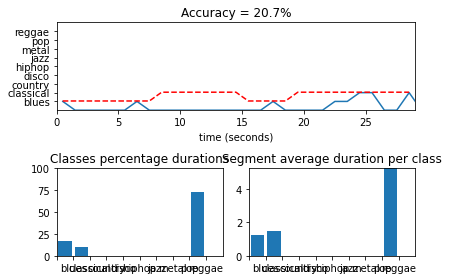

Overall Accuracy: 0.21

Fix-sized segments:
fix-sized segment 0: classical
fix-sized segment 1: country
fix-sized segment 2: country
fix-sized segment 3: country
fix-sized segment 4: country
fix-sized segment 5: disco
fix-sized segment 6: classical
fix-sized segment 7: country
fix-sized segment 8: hiphop
fix-sized segment 9: pop
fix-sized segment 10: country
fix-sized segment 11: disco
fix-sized segment 12: country
fix-sized segment 13: hiphop
fix-sized segment 14: disco
fix-sized segment 15: country
fix-sized segment 16: country
fix-sized segment 17: classical
fix-sized segment 18: country
fix-sized segment 19: country
fix-sized segment 20: pop
fix-sized segment 21: hiphop
fix-sized segment 22: classical
fix-sized segment 23: classical
fix-sized segment 24: metal
fix-sized segment 25: metal
fix-sized segment 26: hiphop
fix-sized segment 27: country
fix-sized segment 28: metal
fix-sized segment 29: blues


FileNotFoundError: [Errno 2] No such file or directory: 'Classification_modelMEANS'

In [114]:
from pyAudioAnalysis.audioSegmentation import mid_term_file_classification, labels_to_segments
from pyAudioAnalysis.audioTrainTest import load_model
labels, class_names, _, _ = mid_term_file_classification("C:\\Users\\saurabh\\Documents\\GitHub\\basic_audio_analysis\\data\\music\\metal_classical_mix.wav", 
                                                         "Classification_model","knn",  True, 
                                                         "C:\\Users\\saurabh\\Documents\\GitHub\\basic_audio_analysis\\data\\\music\\metal_classical_mix.segments")
print("\nFix-sized segments:")
for il, l in enumerate(labels):
    print(f'fix-sized segment {il}: {class_names[int(l)]}')
# load the parameters of the model (actually we just want the mt_step here):    
cl, m, s, m_classes, mt_win, mt_step, s_win, s_step, c_beat = load_model("Classification_model")
# print "merged" segments (use labels_to_segments())
print("\nSegments:")
segs, c = labels_to_segments(labels, mt_step)
for iS, seg in enumerate(segs):
    print(f'segment {iS} {seg[0]} sec - {seg[1]} sec: {class_names[int(c[iS])]}')

In [112]:
import os, sklearn.cluster
from pyAudioAnalysis.MidTermFeatures import mid_feature_extraction as mT
from pyAudioAnalysis.audioBasicIO import read_audio_file, stereo_to_mono
from pyAudioAnalysis.audioSegmentation import labels_to_segments
from pyAudioAnalysis.audioTrainTest import normalize_features
import numpy as np
import scipy.io.wavfile as wavfile
import IPython
# read signal and get normalized segment feature statistics:
input_file = "Downloads\\reggae00005_i9XNZD20.wav"
fs, x = read_audio_file(input_file)
mt_size, mt_step, st_win = 5, 0.5, 0.1
[mt_feats, st_feats, _] = mT(x, fs, mt_size * fs, mt_step * fs,
                            round(fs * st_win), round(fs * st_win * 0.5))
(mt_feats_norm, MEAN, STD) = normalize_features([mt_feats.T])
mt_feats_norm = mt_feats_norm[0].T
# perform clustering
n_clusters = 5
x_clusters = [np.zeros((fs, )) for i in range(n_clusters)]
k_means = sklearn.cluster.KMeans(n_clusters=n_clusters)
k_means.fit(mt_feats_norm.T)
cls = k_means.labels_
# save clusters to concatenated wav files
segs, c = labels_to_segments(cls, mt_step)  # convert flags to segment limits
for sp in range(n_clusters):                
    count_cl = 0
    for i in range(len(c)):     # for each segment in each cluster (>2 secs long)
        if c[i] == sp and segs[i, 1]-segs[i, 0] > 2:
            count_cl += 1
            # get the signal and append it to the cluster's signal (followed by some silence)
            cur_x = x[int(segs[i, 0] * fs): int(segs[i, 1] * fs)]
            x_clusters[sp] = np.append(x_clusters[sp], cur_x)
            x_clusters[sp] = np.append(x_clusters[sp], np.zeros((fs,)))
    # write cluster's signal into a WAV file
    print(f'cluster {sp}: {count_cl} segments {len(x_clusters[sp])/float(fs)} sec total dur')        
    wavfile.write(f'cluster_{sp}.wav', fs, np.int16(x_clusters[sp]))
    IPython.display.display(IPython.display.Audio(f'cluster_{sp}.wav'))

cluster 0: 1 segments 34.5 sec total dur


cluster 1: 1 segments 31.0 sec total dur


cluster 2: 0 segments 1.0 sec total dur


cluster 3: 1 segments 30.5 sec total dur


cluster 4: 1 segments 32.0 sec total dur


In [117]:
from pyAudioAnalysis.audioSegmentation import evaluate_segmentation_classification_dir
dirs = ["C:\\Users\\saurabh\\Downloads\\training_data\\blues",
       "C:\\Users\\saurabh\\Downloads\\training_data\\classical",
       "C:\\Users\\saurabh\\Downloads\\training_data\\country",
       "C:\\Users\\saurabh\\Downloads\\training_data\\disco",
       "C:\\Users\\saurabh\\Downloads\\training_data\\hiphop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\jazz",
       "C:\\Users\\saurabh\\Downloads\\training_data\\metal",
       "C:\\Users\\saurabh\\Downloads\\training_data\\pop",
       "C:\\Users\\saurabh\\Downloads\\training_data\\reggae",
       "C:\\Users\\saurabh\\Downloads\\training_data0\\rock"]

evaluate_segmentation_classification_dir(dir, "Classification_model", "knn")

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'